### 1. Definição do problema <br>
#### 1.1 Contextualização <br>
<p> O subfaturamento de mercadorias importadas é um problema relevante no contexto do coḿercio internacional. 
<br><br> O intento buscado pelos importadores com tal prática é a redução de custos, diminuindo fraudulentamente o preço dos bens importados, visando o menor recolhimento de valores referentes aos  tributos incidentes sobre uma operação de importação. 
</p>

#### 1.2 O problema proposto <br>
<p> Além do prejuízo aos cofres públicos, o subfaturamento do preço de mercadorias importadas é um atentado à concorrência comercial e à indústria nacional, pois reduz artificialmente os custos dos bens importados quando se tem como referência os custos de produtos nacionais. 
<br><br>O objetivo deste trabalho é apresentar uma análise sobre os preços de produtos importados pelo Brasil, comparando os valores declarados numa operação de importação com os preços praticados no comércio internacional.
<br><br>Para isso, primeiramente, será realizado um levantamento de preços junto ao mercado mundial para um grupo de mercadorias de alto valor agregado.
<br><br> Em seguida, buscar-se-ão os preços desses mesmos produtos declarados em processos de importação de mercadorias para o mercado nacional.
<br><br> Por fim, far-se-á a comparação entre as médias desses valores, visando a uma conclusão quanto a indícios de fraudes - subfaturamento ou superfaturamento - nas operações de importação realizadas pelo importador nacional.
</p>


### 2. A coleta de dados <br>
Os datasets usados neste trabalho foram coletados de fontes diversas, na primeira semana de março de 2021. 
<br><br> Definiu-se que os sites __www.aliexpress.com__ e __www.alibaba.com__, notórios fornecedores de produtos diversos, serão objeto de webscrapping realizado com as ferramentas de código aberto _Beautifull Soup_ e _Selenium_, as quais serão utilizadas para coletar uma gama de aproximadamente 1 mil registros de cada um desses sites.
<br><br> Para delimitar o escopo da análise, será definido apenas uma gama de produtos, que apresenta uma variação grande de preços: __display lcd para aparelhos celulares__, NCM 8517.70.99.
<br><br> Como base de comparação de preços, utilizaremos os dados do ano de 2021 das Estatísticas de Comércio Exterior em Dados Abertos, cujas bases podem ser encontradas em __https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncmv2/IMP_2021_V2.csv__, do Portal Comex Stat, acessado em __http://comexstat.mdic.gov.br/pt/home__.

<br> As tabelas abaixo definem os campos dos datasets
    
<table  width=100% align=left>
  <caption>Tabela de preços dos sites</caption>
  <tr>
    <th>Nome do campo</th>
    <th>Descrição</th>
    <th>Tipo</th>
    <th>Valor default</th>
  </tr>
  <tr>
    <td>descricao</td>
    <td>Descrição do produto</td>
    <td>String</td>
    <td> - </td>  
  </tr>
  <tr>
    <td>preco_minimo</td>
    <td>Preço mínimo do produto</td>
    <td>Float</td>
    <td>Se valor menor que 1, preço_min=1</td>
  </tr>
  <tr>
    <td>preco_maximo</td>
    <td>Preço máximo do produto</td>
    <td>Float</td>
    <td>Se menor que preço mínimo, preço_max=preço_min</td>  
  </tr>
  <tr>
    <td>alibaba</td>
    <td>Informa se o dado foi coletado do site Alibaba ou AliExpress</td>
    <td>Boolean</td>
    <td>True, se dado coletado do site AliBaba</td>   
  </tr>
</table>
<br><br>

<table width=100% align=left>
  <caption>Tabela de dados estatísticos</caption>
  <tr>
    <th>Nome do campo</th>
    <th>Descrição</th>
    <th>Tipo</th>
  </tr>
  <tr>
    <td>CO_ANO</td>
    <td>Ano da importação</td>
    <td>Inteiro</td>
    <td> - </td>  
  </tr>
  <tr>
    <td>CO_MES</td>
    <td>Mês da importação</td>
    <td>Inteiro</td>
  </tr>
  <tr>
    <td>CO_NCM</td>
    <td>Código NCM do produto</td>
    <td>Inteiro</td>
  </tr>
  <tr>
    <td>CO_UNID</td>
    <td>Código da unidade estatística</td>
    <td>Inteiro</td>
  </tr>
  <tr>
    <td>CO_PAIS</td>
    <td>Código de país de origem do produto</td>
    <td>Inteiro</td>
  </tr>
  <tr>
    <td>SG_UF_NCM</td>
    <td>código da UF de destino do produto</td>
    <td>String</td>
  </tr>
  <tr>
    <td>CO_VIA</td>
    <td>código da via de transporte</td>
    <td>Inteiro</td>
  </tr>
  <tr>
    <td>CO_URF</td>
    <td align=left>código da Unidade da Receirta Federal de desembarque</td>
    <td>Inteiro</td>
  </tr>
  <tr>
    <td>QT_ESTAT</td>
    <td>quantidade estatística do produto</td>
    <td>Inteiro</td>
  </tr>
  <tr>
    <td>KG_LIQUIDO</td>
    <td>quilograma líquido do produto</td>
    <td>Inteiro</td>
  </tr>
  <tr>
    <td>VL_FOB</td>
    <td>valor FOB,em dólar</td>
    <td>Float</td>
  </tr>
  <tr>
    <td>VL_FRETE</td>
    <td>valor frete,em dólar</td>
    <td>Float</td>
  </tr>
  <tr>
    <td>VL_SEGURO</td>
    <td>valor do seguro,em dólar</td>
    <td>Float</td>
  </tr>
</table>

<br><br><br>

### 3.processamento e o tratamento dos dados <br>


olha dfadsfsda __Bold por favor__ <br>
_Italico Olha isso_ <br>
$ a + bX$ <br>
__________ dfjlkaj dlkjf lkajkdj
> item 
>>item2
>>>item3
- item 1
- item 2
1. item 1
2. item 2 <br>
<font color=blue>"font color=blue"</font><br>
paragrafog <br> outro paragrafo<br>
#isto é comentário
    

In [17]:
#This code scraps 2 sites: AliExpress and AliBaba and saves the data in lista_de_precos.csv
from bs4 import BeautifulSoup
import csv
import pandas as pd

#bibliotecas para requisição de páginas dinâmicas
from selenium import webdriver 
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.firefox.options import Options

import time
import sys
import re
    
def alteraIdioma():
#This function changes AliExpress country to USA, in order to use the dolar currency
    #Mudando o foco do mouse para a paǵina inicial
    user_id = driver.find_element_by_xpath('//*[@id="nav-user-account"]') 
    ActionChains(driver).move_to_element(user_id).click().perform()
    time.sleep(3)

    #Aqui começo a navegar para alterar o idioma
    driver.find_element_by_xpath('//*[@id="switcher-info"]').click()
    time.sleep(3)
    painel = driver.find_element_by_xpath('/html/body/div[2]/div[3]/div/div/div[4]/div/div/div/div[2]/div') # ('/html/body/div[1]/div[3]/div/div/div[4]/div/div')
    painel.click()
    #painel country selector switcher
    time.sleep(3)
    driver.find_element_by_xpath('/html/body/div[2]/div[3]/div/div/div[4]/div/div/div/div[2]/div/a[1]').click()
#    driver.find_element_by_xpath('/html/body/div[1]/div[3]/div/div/div[4]/div/div/div/div[1]/div/a[1]/span/span').click()
    time.sleep(3)
    painel.find_element_by_xpath("/html/body/div[2]/div[3]/div/div/div[4]/div/div/div/div[2]/div/div[1]/ul/li[224]").click()
    time.sleep(1)
    driver.find_element_by_xpath('/html/body/div[2]/div[3]/div/div/div[4]/div/div/div/div[4]/button').click()
    driver.refresh()           

#Preparando a aquisição das páginas
#Criando informação sobre quem está fazendo o scrapping
headers = {
    'User-Agent': 'João Lima, from PUC-MG University',
    'From': 'jbetol@gmail.com'
}

#Verificar se driver para Firefox (o browser que escolhi) está disponível
try:
# from selenium import webdriver
#from selenium.webdriver.firefox.options import Options

    options = Options()
    options.binary_location = '/home/joao/firefox/firefox'
    driver = webdriver.Firefox(executable_path='/home/joao/firefox/geckodriver', options=options)
   # driver = webdriver.Firefox(executable_path = '/home/joao/firefox/geckodriver') #Documents/PosPuc/TCC/projetoTCC/geckodriver')
except IOError:
    sys.exit("Geckodriver not found!")

#Faremos o scrapping nos sites AliExpress e AliBaba, idioma inglês e dólar como moeda.   
url_aliexpress = 'https://www.aliexpress.com/wholesale?trafficChannel=main&d=y&CatId=0&SearchText=phone+display+lcd+for+screen&ltype=wholesale&SortType=default&page='

url_alibaba = 'https://www.alibaba.com/products/phone_display_lcd_screen/CID5904002.html?spm=a2700.galleryofferlist.0.0.126c1524tZVgH8&IndexArea=product_en&page='

paginas = []
qnt_paginas = 3
passou_aliexpress = False # Para controlar a mudança de idioma e moeda
alibaba = False # Vamos começar scrapping por AliExpress.com
site_index = 2  # números de sites a ser scrapping: AliExpress e Alibaba
descricao = []  #descrição das mercadorias tela de lcd para smartphone
preco_min = []
preco_max = []
baba_or_express = [] #Valor booleano para saber origem do item, se AliExpress oou Alibaba

#Vamos pegar 99 páginas de dados (no máximo) de cada site escolhido e jogar num array
while site_index > 0  :
    site_index = site_index - 1

    #Montando a lista de páginas
    for i in range(1,qnt_paginas):
        if not alibaba:
            url = url_aliexpress + str(i)
        else:
            url = url_alibaba + str(i)

        paginas.append(url)

    #Navegando nas páginas de aquisição de dados
    for pagina in paginas:
        driver.get(pagina)

        #O site AliExpress pode estar em português, então temos que alterar para inglês 
        if not alibaba and not passou_aliexpress:
            alteraIdioma()
            passou_aliexpress = True

        req = driver.page_source
        soup = BeautifulSoup(req, "html.parser")

        #Adquirindo a lista dos produtos que se encontra na página carregada
        if alibaba:
            classes = soup.find('div', class_ = "organic-list app-organic-search__list")
            #Agora vamos buscar os itens da lista
            items =  classes.find_all(class_ = 'organic-gallery-offer-outter J-offer-wrapper')
        else:
            classes = soup.find('ul', class_ = "list-items")
            #Agora vamos buscar os itens da lista
            try:
                items =  classes.find_all('div', class_ = 'list-item')
            except AttributeError: # É possível que tenhamos menos páginas do que previsto
                break

        #Para cada item, pegar apenas descrição e o preco e guardar nos arrays
        for item in items:
            if alibaba:
                descricao.append(item.find('h4').get('title'))
                preco = item.find('p', class_ = 'elements-offer-price-normal').get('title')
            else:
                descricao.append(item.find('a', class_ = 'item-title').get('title'))
                preco = item.find('span', class_ = 'price-current').text

            baba_or_express.append(alibaba)
            preco_min_max = re.findall(r'(\d+[\.,]\d{1,2})', preco)
            #é possível que só exista um preço
            if len(preco_min_max) == 1:
                preco_min_max.insert(0,preco_min_max[0]) #para o caso de só ter um preço, faz o mínimo igual ao máximo. 
            preco_min.append(preco_min_max[0])
            preco_max.append(preco_min_max[1])
            
    alibaba = True
    paginas.clear()

driver.quit()
#transformando os dados coletados em DataFrame do Pandas
df = pd.DataFrame({
    'descricao': descricao,
    'preco_minimo': preco_min, 
    'preco_maximo': preco_max,
    'alibaba': baba_or_express
    })
df.info()
# saving the DataFrame as a CSV file 
gfg_csv_data = df.to_csv('lista_de_precos.csv', header = True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   descricao     48 non-null     object
 1   preco_minimo  48 non-null     object
 2   preco_maximo  48 non-null     object
 3   alibaba       48 non-null     bool  
dtypes: bool(1), object(3)
memory usage: 1.3+ KB


In [1]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import re

import itertools
import requests

/home/joao/Documents/PosPuc/TCC/projetoTCC


In [8]:
df = pd.read_csv(Path('Datasets/Imp_Consolidada.csv'), sep=';', encoding='cp1250')
df.info()
df_perc_75 = df.groupby(['CO_NCM'])['VAL_UNIT'].quantile(0.75)
nparray = df_perc_75.to_records()
for ncm, val in nparray.items():
    df.drop(df.index[(df['VAL_UNIT'] > (val-10)) &
                                             (df['CO_NCM'] == ncm)], inplace=True)

df.info()                     


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460046 entries, 0 to 2460045
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   CO_ANO      int64  
 2   CO_MES      int64  
 3   CO_NCM      int64  
 4   CO_PAIS     int64  
 5   SG_UF_NCM   object 
 6   QT_ESTAT    int64  
 7   KG_LIQUIDO  float64
 8   VL_FOB      float64
 9   VL_FRETE    float64
 10  VL_SEGURO   float64
 11  VAL_UNIT    float64
dtypes: float64(5), int64(6), object(1)
memory usage: 225.2+ MB


AttributeError: 'Series' object has no attribute 'to_records'

<AxesSubplot:xlabel='Quantidade', ylabel='Valor_FOB'>

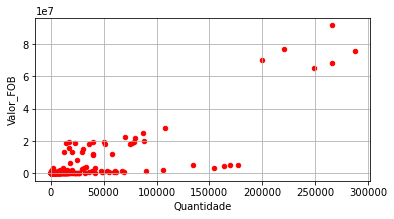

In [119]:
#Preparando tabela de importações
#url_importados = "https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncmv2/IMP_2019_V2.csv"
  
# URL of the file to be downloaded is defined as url_importados
#r = requests.get(url_importados, verify=False) # create HTTP response object, without certification verification
  
#with open("importados_2021.csv",'wb') as csv:
  
    # Saving received content
 
    # write the contents of the response (r.content)
    # to a new csv file.
#    csv.write(r.content)

tab_importados = Path('importados_2021.csv')   

if Path.exists(tab_importados):
    df_importados = pd.read_csv(tab_importados, sep=';')
else:
    print('Arquivo % não encontrado', tab_importados)

#Mostrando os dados do dataframe
#df_importados.info()
    
colunas= ['Ano',
          'Mes',
          'NCM',
          'Unidade_estatistica',
          'Pais_de_origem',
          'UF_destino',
          'Via_de_transporte',
          'Unidade_Receita_Federal',
          'Quantidade',
          'Kg_liquido',
          'Valor_FOB',
          'Valor_frete',
          'Valor_seguro'
          ]
#Changing columns names
df_importados.columns = colunas

#Selecionando apenas as colunas de interesse para nossa comparação e deletando as demais
#Para isso, manteremos, por enquanto, apenas as colunas Mês, NCM, País de origem, Quantidade e Valor FOB. 
#As demais não interferirão nas nossas avaliações.
cols_to_drop = ['Ano',
          'Unidade_estatistica',
          'Pais_de_origem',      
          'UF_destino',
          'Via_de_transporte',
          'Unidade_Receita_Federal',
          'Kg_liquido',
          'Valor_frete',
          'Valor_seguro'
          ]
df_importados.drop(cols_to_drop, axis=1, inplace=True)

#Precisamos agora selecionar da tabela de importados as mercadorias de nosso interesse, que se inserem 
#na classificação fiscal de código NCM = 85177099
df_importados = df_importados[df_importados.NCM==85177099]

#********************Próximos passos******************************#
#Calcular valor unitário, por registro.
#Verificamos que algumas linhas de dados contém o campo Quantidade ou Valor_FOB igual a ZERO.
#Apagaremos esses registros, uma vez que os campos serão usados para calcular o valor unitário e 
#não usaremos a média para completar esses registros por que não fizemos o tratamento dos outliers ainda.
df_importados.drop(df_importados.index[df_importados['Quantidade'] == 0], inplace=True)
df_importados.drop(df_importados.index[df_importados['Valor_FOB'] == 0], inplace=True)

#Agora calcularemos os valores unitários referente a cada operação de importação.
df_importados.eval("Val_unitario = Valor_FOB/Quantidade", target = df_importados, inplace = True)

#Mostrar gráfico com valores
df_importados.plot.scatter(x='Quantidade',y='Valor_FOB', grid=True, c='red',figsize=[6,3], layout=[1,2])

#Calcular os outliers
#Usar estratégia de outliers
# calcular a média de Fob e Quantidade




#Calcular média dos valores unitários.

#Calcular média dos valores unitários dos dados coletados nos sites.




# Re-assignment operation drops columns not in colunas
#df_importados.head()  
#df_importados.info()
#(df_importados.NCM==85177099).sum()

count    866.000000
mean      89.553164
std       92.589008
min        0.051724
25%       16.411222
50%       50.653226
75%      140.302002
max      352.375000
Name: Val_unitario, dtype: float64

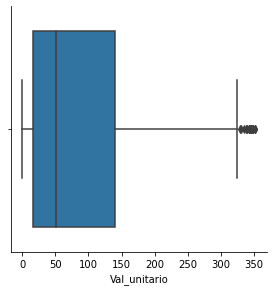

In [120]:
df_importados.drop(df_importados.index[df_importados['Val_unitario'] > 354], inplace=True)
#df_importados.boxplot(column=['Quantidade','Valor_FOB'], figsize=[10,15])

f = pd.melt(df_importados, value_vars=['Val_unitario'])#,'Quantidade']) #, 'Val_unitario'])
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height = 4)
#g = g.map(sns.histplot, "value")
sns.boxplot(x='Val_unitario',data=df_importados)
df_importados['Val_unitario'].describe()

p25 = %s, p75 = %s, iqr = %s  16.411221963448362 140.30200176424103 123.89077980079267


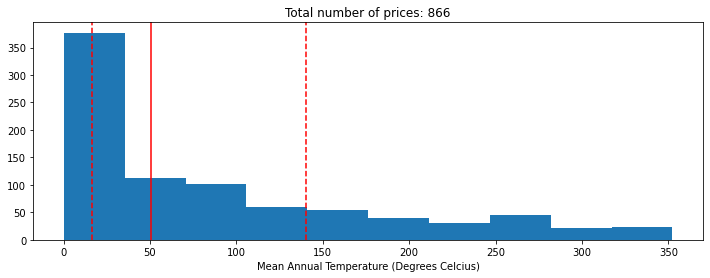

In [132]:
#Vamos identificar outliers utilizando o método de -1,5*IQR até 1,5*IQR (Intervalor interquartílico) em relação aos
#valores unitários
#Para calcular o IQR, temos que ordenar os dados em ordem crescente, usando o campo alvo como índice.
df_importados = df_importados.sort_values(by='Val_unitario').reset_index(drop=True)
p25 = df_importados["Val_unitario"].quantile(0.25)
p75 = df_importados['Val_unitario'].quantile(0.75)
iqr = p75 - p25
print("p25 = %s, p75 = %s, iqr = %s ", p25, p75, iqr)
#df_importados.describe()

#Valores acima 
plt.figure(figsize=(12,4))
plt.hist(df_importados['Val_unitario'])
plt.title("Total number of prices: %s" % len(df_importados.index))
plt.xlabel("Mean Annual Temperature (Degrees Celcius)")

# Vertical lines for each percentile of interest
plt.axvline(df_importados['Val_unitario'].quantile(0.25), linestyle='--', color='red')
plt.axvline(df_importados['Val_unitario'].quantile(0.50), linestyle='-',  color='red')
plt.axvline(df_importados['Val_unitario'].quantile(0.75), linestyle='--', color='red')

plt.show()


In [133]:
#Verifica arquivo de dados obtido using scrapping technics
tab_precos = Path('listaNova.csv')
if Path.exists(tab_precos):
    df_precos = pd.read_csv(tab_precos)
else:
    print("Arquivo %s não encontrado", tab_precos)

In [134]:
#Transformando preços em float
df_precos['preco_minimo'] = pd.to_numeric(df_precos.preco_minimo, errors = 'coerce')
df_precos['preco_maximo'] = pd.to_numeric(df_precos.preco_maximo, errors = 'coerce')
df_precos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2760 non-null   int64  
 1   descricao     2760 non-null   object 
 2   preco_minimo  2753 non-null   float64
 3   preco_maximo  2759 non-null   float64
 4   alibaba       2760 non-null   bool   
dtypes: bool(1), float64(2), int64(1), object(1)
memory usage: 89.1+ KB


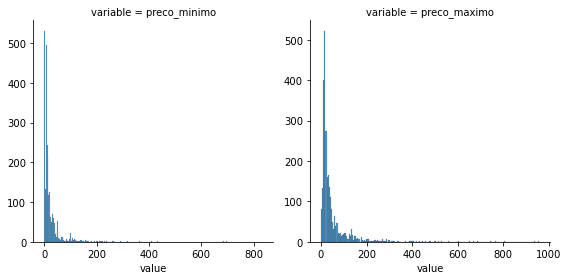

In [135]:
f = pd.melt(df_precos, value_vars=['preco_minimo','preco_maximo'])
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height = 4)
g = g.map(sns.histplot, "value")

<AxesSubplot:xlabel='preco_minimo', ylabel='preco_maximo'>

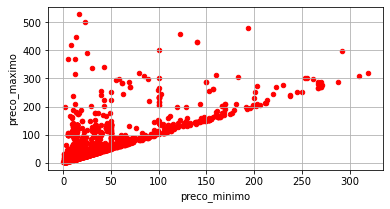

In [143]:
df_precos.plot.scatter(x='preco_minimo',y='preco_maximo', grid=True, c='red',figsize=[6,3], layout=[1,2])


In [137]:
#Preparando limpeza de linhas que não parecem ser de telas LCD
# 1. Selecionando só linhas que contém o termo LCD.
#df_precos['selecionada'] = df_precos.descricao.str.contains('lcd',case=False) #('[Cc]harge|[Aa]dhesive|[Tt]ool[s]|[Gg]lue|[Ss]ticker|[Cc]lip|[Mm]achine')
#df_precos.drop((df_precos[df_precos['selecionada']==False].index), inplace=True) # deleta o que não contém é LCD

#nao_lcds = '[Cc]harge|[Aa]dhesive|[Tt]ool[s]|[Gg]lue|[Ss]ticker|[Cc]lip|[Mm]achine'
#df_precos['selecionada'] = df_precos.descricao.str.contains(nao_lcds)
#df_precos.drop((df_precos[df_precos['selecionada']==True].index), inplace=True) # deleta o que não parece ser lcd
#df_precos.info()

In [144]:
#Converter preços mínimos menores que 1 em preço máximo
df_precos.loc[(df_precos['preco_minimo'] < 1 ) ,'preco_minimo'] = df_precos.preco_maximo
df_precos.head()

,Unnamed: 0,descricao,preco_minimo,preco_maximo,alibaba,preco_medio
0,344,Screen-Fpc-Connector Smart-Phone Cltgxdd Board...,0.36,0.36,False,0.36
1,101,Lcd-Display Wire-Line Screen-Separator-Repair ...,0.46,0.46,False,0.46
2,129,Stickers Adhesive Touch-Screen iPhone 6s Water...,0.55,0.55,False,0.55
3,325,Lcd-Display Screen-Separator-Repair Repair-Too...,0.58,0.58,False,0.58
4,1,Sticker Adhesive-Tape Cellphone Touch-Screen M...,0.59,0.59,False,0.59


In [139]:
#df_precos.info()
df_precos.eval("preco_medio = (preco_minimo+preco_maximo)/2", target = df_precos, inplace = True)
df_precos.describe() # estatísticas do dataframe


df_precos = df_precos.sort_values(by='preco_medio').reset_index(drop=True)
p25 = df_precos["preco_medio"].quantile(0.25)
p75 = df_precos['preco_medio'].quantile(0.75)
iqr = p75 - p25
print("p25 = %s, p75 = %s, iqr = %s ", p25, p75, iqr)


p25 = %s, p75 = %s, iqr = %s  12.698749999999999 41.48625 28.7875


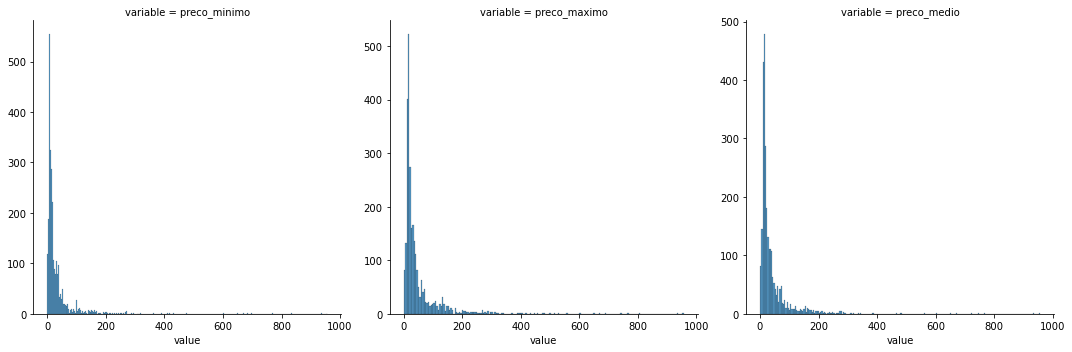

In [140]:
f = pd.melt(df_precos, value_vars=['preco_minimo','preco_maximo', 'preco_medio'])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, height = 5,grid=)
g = g.map(sns.histplot, "value")


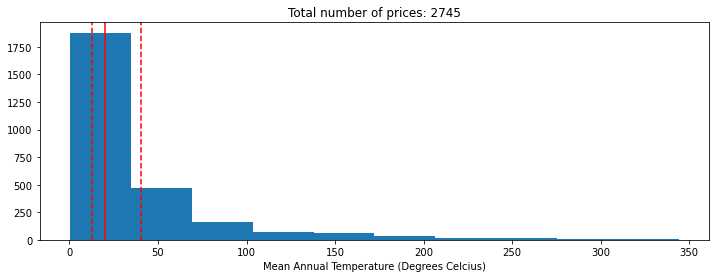

In [145]:
#sns.boxplot(x='preco_medio',data=df_precos)
plt.figure(figsize=(12,4))
plt.hist(df_precos['preco_medio'])
plt.title("Total number of prices: %s" % len(df_precos.index))
plt.xlabel("Mean Annual Temperature (Degrees Celcius)")

# Vertical lines for each percentile of interest
plt.axvline(df_precos['preco_medio'].quantile(0.25), linestyle='--', color='red')
plt.axvline(df_precos['preco_medio'].quantile(0.50), linestyle='-',  color='red')
plt.axvline(df_precos['preco_medio'].quantile(0.75), linestyle='--', color='red')

plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2745 entries, 0 to 2759
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2745 non-null   int64  
 1   descricao     2745 non-null   object 
 2   preco_minimo  2738 non-null   float64
 3   preco_maximo  2744 non-null   float64
 4   alibaba       2745 non-null   bool   
 5   preco_medio   2737 non-null   float64
dtypes: bool(1), float64(3), int64(1), object(1)
memory usage: 211.4+ KB


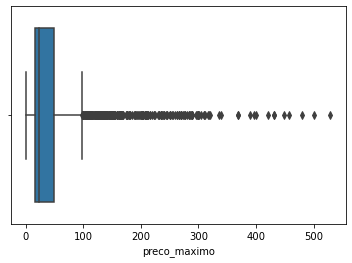

In [146]:
df_precos.drop(df_precos.index[df_precos['preco_medio'] > 354], inplace=True)

sns.boxplot(x='preco_maximo',data=df_precos)
df_precos.info()


In [2]:
import pandas as pd
dfpais = pd.read_csv('Datasets/pais.csv', sep=';', encoding='cp1250')
dfimp  = pd.read_csv('Datasets/importacoes2019.csv', sep=';', encoding='cp1250')


In [3]:
dfjunto = dfimp.merge(dfpais, on='CO_PAIS', how='left')

In [4]:
dfjunto.head()

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO,CO_PAIS_ISON3,CO_PAIS_ISOA3,NO_PAIS,NO_PAIS_ING,NO_PAIS_ESP
0,2019,6,85439090,10,399,SC,4,817600,1,1,15,7,0,392,JPN,Japăo,Japan,Japón
1,2019,12,56041000,10,160,SC,1,927800,453,453,1889,81,4,156,CHN,China,China,China
2,2019,2,85365090,11,87,AM,4,227700,4,0,203,4,0,56,BEL,Bélgica,Belgium,Bélgica
3,2019,7,39269090,10,247,PR,1,917800,167,167,1477,499,0,703,SVK,Eslováquia,Slovakia,Eslovaquia
4,2019,12,62021300,11,160,ES,4,817600,16,5,1603,54,2,156,CHN,China,China,China
